In [2]:
import statsapi
import pandas as pd

In [3]:
# Test pulling info for Ohtani
player_info = statsapi.get('person', {'personId': 660271})
print(player_info)

{'copyright': 'Copyright 2025 MLB Advanced Media, L.P.  Use of any content on this page acknowledges agreement to the terms posted here http://gdx.mlb.com/components/copyright.txt', 'people': [{'id': 660271, 'fullName': 'Shohei Ohtani', 'link': '/api/v1/people/660271', 'firstName': 'Shohei', 'lastName': 'Ohtani', 'primaryNumber': '17', 'birthDate': '1994-07-05', 'currentAge': 30, 'birthCity': 'Oshu', 'birthCountry': 'Japan', 'height': '6\' 3"', 'weight': 210, 'active': True, 'primaryPosition': {'code': 'Y', 'name': 'Two-Way Player', 'type': 'Two-Way Player', 'abbreviation': 'TWP'}, 'useName': 'Shohei', 'useLastName': 'Ohtani', 'boxscoreName': 'Ohtani', 'nickName': 'Showtime', 'gender': 'M', 'isPlayer': True, 'isVerified': False, 'pronunciation': 'show-HEY oh-TAWN-ee', 'mlbDebutDate': '2018-03-29', 'batSide': {'code': 'L', 'description': 'Left'}, 'pitchHand': {'code': 'R', 'description': 'Right'}, 'nameFirstLast': 'Shohei Ohtani', 'nameSlug': 'shohei-ohtani-660271', 'firstLastName': 'Sh

In [4]:
# DONT RUN THIS IT TAKES A WHILE
# def get_team_ids():
#     teams = statsapi.get('teams', {'sportId': 1})['teams']
#     return [team['id'] for team in teams]

# def get_players_from_team(team_id, season='2021'):
#     roster = statsapi.get('team_roster', {'teamId': team_id, 'season': season})
#     return roster['roster']

# def get_player_info_flat(player_id):
#     person = statsapi.get('person', {'personId': player_id})
#     info = person['people'][0]

#     return {
#         'id': info.get('id'),
#         'fullName': info.get('fullName'),
#         'birthDate': info.get('birthDate'),
#         'birthCountry': info.get('birthCountry'),
#         'height': info.get('height'),
#         'weight': info.get('weight'),
#         'primaryPosition': info.get('primaryPosition', {}).get('abbreviation'),
#         'batSide': info.get('batSide', {}).get('code'),
#         'pitchHand': info.get('pitchHand', {}).get('code'),
#         'debutDate': info.get('mlbDebutDate'),
#         'active': info.get('active'),
#     }

# def get_all_players_df(season='2021'):
#     team_ids = get_team_ids()
#     player_data = []

#     for team_id in team_ids:
#         players = get_players_from_team(team_id, season)
#         for player in players:
#             player_id = player['person']['id']
#             info = get_player_info_flat(player_id)
#             player_data.append(info)

#     df = pd.DataFrame(player_data)
#     return df

# df_players = get_all_players_df()
# print(df_players.head())


In [5]:
# df_players.head()

In [6]:
# df_players.to_csv('mlb_players_2021.csv', index=False)

### **Only run the code below here because everyone should have the two dfs on their computer !**

In [7]:
players = pd.read_csv("mlb_players_2021.csv")
pitches = pd.read_csv("regseason.csv")

In [8]:
players.rename(columns={"id" : "batter","fullName" : "batter_fullName" , "birthCountry" : "batter_birthCountry"}, inplace=True)
players.head()

,batter,batter_fullName,birthDate,batter_birthCountry,height,weight,primaryPosition,batSide,pitchHand,debutDate,active
0,642758,Domingo Acevedo,1994-03-06,Dominican Republic,"6' 7""",240,P,R,R,2021-06-21,True
1,664119,Austin Allen,1994-01-16,USA,"6' 1""",219,C,L,R,2019-05-11,False
2,462101,Elvis Andrus,1988-08-26,Venezuela,"6' 0""",210,SS,R,R,2009-04-06,False
3,642456,Luis Barrera,1995-11-15,Dominican Republic,"6' 0""",195,OF,L,L,2021-05-19,True
4,605135,Chris Bassitt,1989-02-22,USA,"6' 5""",217,P,R,R,2014-08-30,True


In [9]:
pitches.head()

,Unnamed: 0,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,...,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,count,PBhand,pitch_cat
0,1,SL,2021-10-03,85.1,2.39,6.05,"Detmers, Reid",641487,672282,single,hit_into_play,NaN,NaN,NaN,NaN,3.0,J.P. Crawford singles on a ground ball to cent...,R,L,L,SEA,LAA,X,8.0,ground_ball,0,1,2021,-0.12,-0.40,0.58,3.44,NaN,672284.0,NaN,2,2,Bot,127.68,100.38,...,84.6,2224.0,5.8,632237,672282,435559.0,665120.0,664058.0,608686.0,650859.0,594838.0,501571.0,670351.0,54.74,0.254,0.229,0.9,1.0,1.0,0.0,2.0,23,2,Slider,1,4,1,4,4,2,2,4,Standard,Standard,293.0,0.079,0.780,0_1,bLpL,breaking
1,2,FF,2021-10-03,93.8,2.31,6.03,"Detmers, Reid",641487,672282,NaN,foul,NaN,NaN,NaN,NaN,2.0,J.P. Crawford singles on a ground ball to cent...,R,L,L,SEA,LAA,S,NaN,NaN,0,0,2021,0.74,1.45,0.05,3.25,NaN,672284.0,NaN,2,2,Bot,NaN,NaN,...,93.3,1959.0,5.9,632237,672282,435559.0,665120.0,664058.0,608686.0,650859.0,594838.0,501571.0,670351.0,54.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23,1,4-Seam Fastball,1,4,1,4,4,1,1,4,Standard,Standard,150.0,0.000,-0.045,0_0,bLpL,fastball
2,3,CU,2021-10-03,73.9,2.12,6.25,"Detmers, Reid",664238,672282,strikeout,called_strike,NaN,NaN,NaN,NaN,8.0,Dylan Moore called out on strikes.,R,R,L,SEA,LAA,S,2.0,NaN,2,2,2021,-1.15,-1.36,0.25,1.67,NaN,672284.0,NaN,1,2,Bot,NaN,NaN,...,72.4,2580.0,5.5,632237,672282,435559.0,665120.0,664058.0,608686.0,650859.0,594838.0,501571.0,670351.0,54.97,NaN,NaN,0.0,1.0,0.0,0.0,NaN,22,6,Curveball,1,4,1,4,4,1,1,4,Standard,Standard,329.0,-0.032,-0.315,2_2,bRpL,breaking
3,4,FF,2021-10-03,94.6,2.43,5.96,"Detmers, Reid",664238,672282,NaN,ball,NaN,NaN,NaN,NaN,13.0,Dylan Moore called out on strikes.,R,R,L,SEA,LAA,B,NaN,NaN,1,2,2021,0.60,1.40,-0.98,1.91,NaN,672284.0,NaN,1,2,Bot,NaN,NaN,...,93.9,2152.0,5.9,632237,672282,435559.0,665120.0,664058.0,608686.0,650859.0,594838.0,501571.0,670351.0,54.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22,5,4-Seam Fastball,1,4,1,4,4,1,1,4,Standard,Standard,146.0,0.000,0.047,1_2,bRpL,fastball
4,5,FF,2021-10-03,94.3,2.08,6.15,"Detmers, Reid",664238,672282,NaN,foul,NaN,NaN,NaN,NaN,5.0,Dylan Moore called out on strikes.,R,R,L,SEA,LAA,S,NaN,NaN,1,2,2021,0.80,1.44,0.22,2.70,NaN,672284.0,NaN,1,2,Bot,NaN,NaN,...,93.7,2180.0,6.0,632237,672282,435559.0,665120.0,664058.0,608686.0,650859.0,594838.0,501571.0,670351.0,54.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22,4,4-Seam Fastball,1,4,1,4,4,1,1,4,Standard,Standard,151.0,0.000,0.000,1_2,bRpL,fastball


In [10]:
# Merge pitches df with info about the batter
full_df = pd.merge(pitches, players[["batter","batter_fullName","batSide", "batter_birthCountry"]], on="batter")
full_df.head()

,Unnamed: 0,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,...,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,count,PBhand,pitch_cat,batter_fullName,batSide,batter_birthCountry
0,1,SL,2021-10-03,85.1,2.39,6.05,"Detmers, Reid",641487,672282,single,hit_into_play,NaN,NaN,NaN,NaN,3.0,J.P. Crawford singles on a ground ball to cent...,R,L,L,SEA,LAA,X,8.0,ground_ball,0,1,2021,-0.12,-0.40,0.58,3.44,NaN,672284.0,NaN,2,2,Bot,127.68,100.38,...,632237,672282,435559.0,665120.0,664058.0,608686.0,650859.0,594838.0,501571.0,670351.0,54.74,0.254,0.229,0.9,1.0,1.0,0.0,2.0,23,2,Slider,1,4,1,4,4,2,2,4,Standard,Standard,293.0,0.079,0.780,0_1,bLpL,breaking,J.P. Crawford,L,USA
1,2,FF,2021-10-03,93.8,2.31,6.03,"Detmers, Reid",641487,672282,NaN,foul,NaN,NaN,NaN,NaN,2.0,J.P. Crawford singles on a ground ball to cent...,R,L,L,SEA,LAA,S,NaN,NaN,0,0,2021,0.74,1.45,0.05,3.25,NaN,672284.0,NaN,2,2,Bot,NaN,NaN,...,632237,672282,435559.0,665120.0,664058.0,608686.0,650859.0,594838.0,501571.0,670351.0,54.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23,1,4-Seam Fastball,1,4,1,4,4,1,1,4,Standard,Standard,150.0,0.000,-0.045,0_0,bLpL,fastball,J.P. Crawford,L,USA
2,3,CU,2021-10-03,73.9,2.12,6.25,"Detmers, Reid",664238,672282,strikeout,called_strike,NaN,NaN,NaN,NaN,8.0,Dylan Moore called out on strikes.,R,R,L,SEA,LAA,S,2.0,NaN,2,2,2021,-1.15,-1.36,0.25,1.67,NaN,672284.0,NaN,1,2,Bot,NaN,NaN,...,632237,672282,435559.0,665120.0,664058.0,608686.0,650859.0,594838.0,501571.0,670351.0,54.97,NaN,NaN,0.0,1.0,0.0,0.0,NaN,22,6,Curveball,1,4,1,4,4,1,1,4,Standard,Standard,329.0,-0.032,-0.315,2_2,bRpL,breaking,Dylan Moore,R,USA
3,4,FF,2021-10-03,94.6,2.43,5.96,"Detmers, Reid",664238,672282,NaN,ball,NaN,NaN,NaN,NaN,13.0,Dylan Moore called out on strikes.,R,R,L,SEA,LAA,B,NaN,NaN,1,2,2021,0.60,1.40,-0.98,1.91,NaN,672284.0,NaN,1,2,Bot,NaN,NaN,...,632237,672282,435559.0,665120.0,664058.0,608686.0,650859.0,594838.0,501571.0,670351.0,54.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22,5,4-Seam Fastball,1,4,1,4,4,1,1,4,Standard,Standard,146.0,0.000,0.047,1_2,bRpL,fastball,Dylan Moore,R,USA
4,5,FF,2021-10-03,94.3,2.08,6.15,"Detmers, Reid",664238,672282,NaN,foul,NaN,NaN,NaN,NaN,5.0,Dylan Moore called out on strikes.,R,R,L,SEA,LAA,S,NaN,NaN,1,2,2021,0.80,1.44,0.22,2.70,NaN,672284.0,NaN,1,2,Bot,NaN,NaN,...,632237,672282,435559.0,665120.0,664058.0,608686.0,650859.0,594838.0,501571.0,670351.0,54.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22,4,4-Seam Fastball,1,4,1,4,4,1,1,4,Standard,Standard,151.0,0.000,0.000,1_2,bRpL,fastball,Dylan Moore,R,USA


In [11]:
# Remove the pitches that were fouled, in play, or swung at
not_hit = ["called_strike", "ball"]
pitches_not_hit = full_df[full_df['description'].isin(not_hit)].copy()
len(pitches_not_hit)

390288

So we have 390,000 pitches to work with that were thrown but not swung at or hit

In [12]:
# Check that we only have balls and called strikes
pitches_not_hit['description'].unique()

array(['called_strike', 'ball'], dtype=object)

In [13]:
pitches_not_hit["strike_zone"] = pitches_not_hit["zone"] <= 9 # Determine if the pitch was actually in the zone

pitches_not_hit["called_correctly"] = (
    ((pitches_not_hit["zone"] <= 9) & (pitches_not_hit["type"] == "S")) | # Pitch is in the zone and is called a strike  
    ((pitches_not_hit["zone"] > 9) & (pitches_not_hit["type"] == "B"))    # Pitch is not in the zone and is called a ball
) 
pitches_not_hit["called_correctly"] = pitches_not_hit["called_correctly"].astype(int) # This will be are target variable -- whether the pitch was called "correctly"

In [14]:
# Check how many pitches we have that were "called correctly"
len(pitches_not_hit[pitches_not_hit["called_correctly"] == 1])

357779

In [15]:
# Check how many pitches we have that were not "called correctly"
len(pitches_not_hit[pitches_not_hit["called_correctly"] == 0])

32509

In [41]:
from sklearn.model_selection import train_test_split
y = pitches_not_hit["called_correctly"]
X= pitches_not_hit.drop(["called_correctly"], axis= 1)
X = X.dropna(axis=1, how='all')
X_train, X_test, y_train, y_test = train_test_split(X, y)
X.head()

,Unnamed: 0,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,fielder_2,vx0,vy0,vz0,ax,ay,az,...,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,woba_value,woba_denom,babip_value,iso_value,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,count,PBhand,pitch_cat,batter_fullName,batSide,batter_birthCountry,strike_zone
2,3,CU,2021-10-03,73.9,2.12,6.25,"Detmers, Reid",664238,672282,strikeout,called_strike,8.0,Dylan Moore called out on strikes.,R,R,L,SEA,LAA,S,2.0,2,2,2021,-1.15,-1.36,0.25,1.67,NaN,672284.0,NaN,1,2,Bot,435559.0,-1.804065,-107.530072,0.417898,-8.418054,21.863846,-42.939575,...,2580.0,5.5,632237,672282,435559.0,665120.0,664058.0,608686.0,650859.0,594838.0,501571.0,670351.0,54.97,0.0,1.0,0.0,0.0,22,6,Curveball,1,4,1,4,4,1,1,4,Standard,Standard,329.0,-0.032,-0.315,2_2,bRpL,breaking,Dylan Moore,R,USA,True
3,4,FF,2021-10-03,94.6,2.43,5.96,"Detmers, Reid",664238,672282,NaN,ball,13.0,Dylan Moore called out on strikes.,R,R,L,SEA,LAA,B,NaN,1,2,2021,0.60,1.40,-0.98,1.91,NaN,672284.0,NaN,1,2,Bot,435559.0,-10.117308,-137.236366,-7.944571,9.751929,28.545925,-12.795040,...,2152.0,5.9,632237,672282,435559.0,665120.0,664058.0,608686.0,650859.0,594838.0,501571.0,670351.0,54.59,NaN,NaN,NaN,NaN,22,5,4-Seam Fastball,1,4,1,4,4,1,1,4,Standard,Standard,146.0,0.000,0.047,1_2,bRpL,fastball,Dylan Moore,R,USA,False
6,7,FF,2021-10-03,94.2,2.33,5.94,"Detmers, Reid",664238,672282,NaN,ball,13.0,Dylan Moore called out on strikes.,R,R,L,SEA,LAA,B,NaN,0,1,2021,0.47,1.41,-1.52,2.45,NaN,672284.0,NaN,1,2,Bot,435559.0,-10.946803,-136.643800,-6.448598,8.243402,30.057992,-13.170447,...,2095.0,6.1,632237,672282,435559.0,665120.0,664058.0,608686.0,650859.0,594838.0,501571.0,670351.0,54.40,NaN,NaN,NaN,NaN,22,2,4-Seam Fastball,1,4,1,4,4,1,1,4,Standard,Standard,145.0,0.000,0.032,0_1,bRpL,fastball,Dylan Moore,R,USA,False
9,10,CU,2021-10-03,73.9,2.22,6.23,"Detmers, Reid",663728,672282,NaN,ball,12.0,"Cal Raleigh grounds out, second baseman David ...",R,R,L,SEA,LAA,B,NaN,2,2,2021,-1.18,-1.31,0.48,3.39,NaN,NaN,672284.0,0,2,Bot,435559.0,-1.463728,-107.423218,3.781709,-8.776083,20.762539,-43.178594,...,2348.0,5.6,632237,672282,435559.0,665120.0,664058.0,608686.0,650859.0,594838.0,501571.0,670351.0,54.94,NaN,NaN,NaN,NaN,21,7,Curveball,1,4,1,4,4,1,1,4,Standard,Standard,322.0,0.000,0.174,2_2,bRpL,breaking,Cal Raleigh,S,USA,False
12,13,FF,2021-10-03,94.4,2.48,5.97,"Detmers, Reid",663728,672282,NaN,ball,12.0,"Cal Raleigh grounds out, second baseman David ...",R,R,L,SEA,LAA,B,NaN,1,2,2021,0.84,1.29,1.58,2.88,NaN,NaN,672284.0,0,2,Bot,435559.0,-4.151318,-137.422945,-5.219095,11.500040,29.263682,-14.808073,...,2062.0,5.7,632237,672282,435559.0,665120.0,664058.0,608686.0,650859.0,594838.0,501571.0,670351.0,54.76,NaN,NaN,NaN,NaN,21,4,4-Seam Fastball,1,4,1,4,4,1,1,4,Standard,Standard,148.0,0.000,0.062,1_2,bRpL,fastball,Cal Raleigh,S,USA,False


In [42]:
from itertools import combinations
from sklearn.linear_model import LogisticRegression


# these are not actually all the columns: you'll 
# need to add any of the other ones you want to search for
all_quant_cols = ['Unnamed: 0', 'release_speed', 'release_pos_x', 'release_pos_z', 'batter', 'pitcher',
 'zone', 'hit_location', 'balls', 'strikes', 'game_year', 'pfx_x', 'pfx_z', 'plate_x', 
 'plate_z', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up', 'inning', 'fielder_2', 'vx0', 
 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate', 'release_extension', 'game_pk', 
 'pitcher.1', 'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 
 'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y', 'woba_value', 'woba_denom', 
 'babip_value', 'iso_value', 'at_bat_number', 'pitch_number', 'home_score', 'away_score', 
 'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
 'post_fld_score', 'spin_axis', 'delta_home_win_exp', 'delta_run_exp'
 ]


all_qual_cols = [
    'pitch_type', 'game_date', 'player_name', 'events', 'description', 'des', 'game_type',
 'stand', 'p_throws', 'home_team', 'away_team', 'type', 'inning_topbot', 'pitch_name',
 'if_fielding_alignment', 'of_fielding_alignment', 'count', 'PBhand', 'pitch_cat', 
 'batter_fullName', 'batSide', 'batter_birthCountry', 'strike_zone']

best_score = 0

for qual in all_qual_cols:
    for pair in combinations(all_quant_cols, 2): 
        cols = list(pair) + [qual]  # use just the current qualitative column
        try:
            # Drop rows with NaNs in selected columns only
            X_sub = X_train[cols].dropna()
            y_sub = y_train.loc[X_sub.index]
            
            LR = LogisticRegression()
            LR.fit(X_sub, y_sub)
            score = LR.score(X_sub, y_sub)
            
            if score > best_score:
                best_score = score
                best_cols = cols
        except KeyError:
            print(f"Skipping combo due to missing column: {cols}")
        except ValueError:
            print(f"Skipping combo due to incompatible data types: {cols}")

Skipping combo due to incompatible data types: ['Unnamed: 0', 'release_speed', 'pitch_type']
Skipping combo due to incompatible data types: ['Unnamed: 0', 'release_pos_x', 'pitch_type']
Skipping combo due to incompatible data types: ['Unnamed: 0', 'release_pos_z', 'pitch_type']
Skipping combo due to incompatible data types: ['Unnamed: 0', 'batter', 'pitch_type']
Skipping combo due to incompatible data types: ['Unnamed: 0', 'pitcher', 'pitch_type']
Skipping combo due to incompatible data types: ['Unnamed: 0', 'zone', 'pitch_type']
Skipping combo due to incompatible data types: ['Unnamed: 0', 'hit_location', 'pitch_type']
Skipping combo due to incompatible data types: ['Unnamed: 0', 'balls', 'pitch_type']
Skipping combo due to incompatible data types: ['Unnamed: 0', 'strikes', 'pitch_type']
Skipping combo due to incompatible data types: ['Unnamed: 0', 'game_year', 'pitch_type']
Skipping combo due to incompatible data types: ['Unnamed: 0', 'pfx_x', 'pitch_type']
Skipping combo due to inco

/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Skipping combo due to incompatible data types: ['Unnamed: 0', 'release_speed', 'PBhand']
Skipping combo due to incompatible data types: ['Unnamed: 0', 'release_pos_x', 'PBhand']
Skipping combo due to incompatible data types: ['Unnamed: 0', 'release_pos_z', 'PBhand']
Skipping combo due to incompatible data types: ['Unnamed: 0', 'batter', 'PBhand']
Skipping combo due to incompatible data types: ['Unnamed: 0', 'pitcher', 'PBhand']
Skipping combo due to incompatible data types: ['Unnamed: 0', 'zone', 'PBhand']
Skipping combo due to incompatible data types: ['Unnamed: 0', 'hit_location', 'PBhand']
Skipping combo due to incompatible data types: ['Unnamed: 0', 'balls', 'PBhand']
Skipping combo due to incompatible data types: ['Unnamed: 0', 'strikes', 'PBhand']
Skipping combo due to incompatible data types: ['Unnamed: 0', 'game_year', 'PBhand']
Skipping combo due to incompatible data types: ['Unnamed: 0', 'pfx_x', 'PBhand']
Skipping combo due to incompatible data types: ['Unnamed: 0', 'pfx_z',

/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

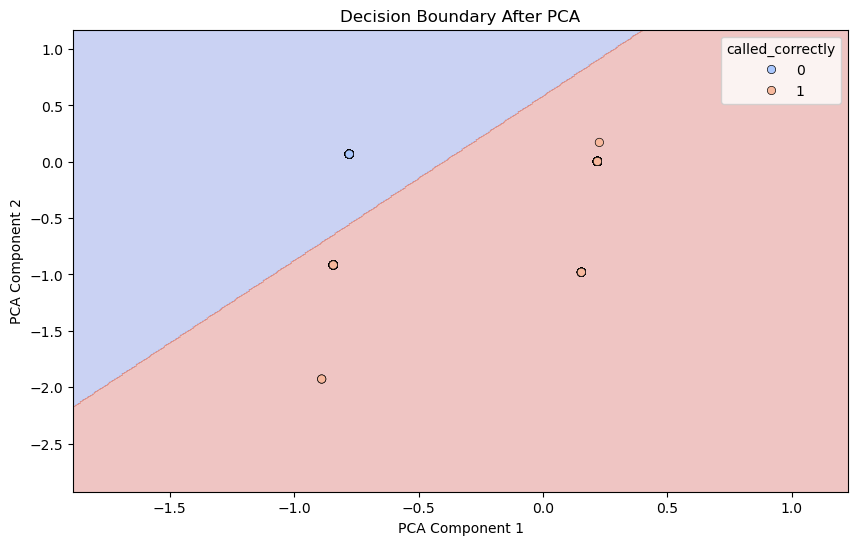

(8183, 3)

In [48]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Drop NAs and align y
X_best = X_train[best_cols].dropna()
y_best = y_train.loc[X_best.index]

# Step 1: Reduce to 2D with PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_best)

# Step 2: Fit Logistic Regression
LR_pca = LogisticRegression()
LR_pca.fit(X_pca, y_best)

# Step 3: Plot decision boundary
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))
Z = LR_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plotting
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_best, palette='coolwarm', edgecolor='k')
plt.title('Decision Boundary After PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

X_train[best_cols].dropna().shape

So there are aound 360,000 correctly called pitches at 32,000 which are not called correctly -- we might want to consider removing some of the correctly called pitches so that we have the same amount for each. But 64,000 data points should be enough for training our model. 